In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [2]:
def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


In [3]:
dataset

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922
...,...,...,...,...,...,...,...,...,...,...
50280,168,24,2008-05-27 20:45:42,1.325079,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312
50281,168,24,2008-05-27 20:45:42,1.325079,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062
50282,168,24,2008-05-27 20:45:42,1.325079,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828
50283,168,24,2008-05-27 20:45:42,1.325079,3.587336,0.001219,34.565580,0.0006,0.000,2810.640


Text(0.5, 1.0, 'Discharge B0005')

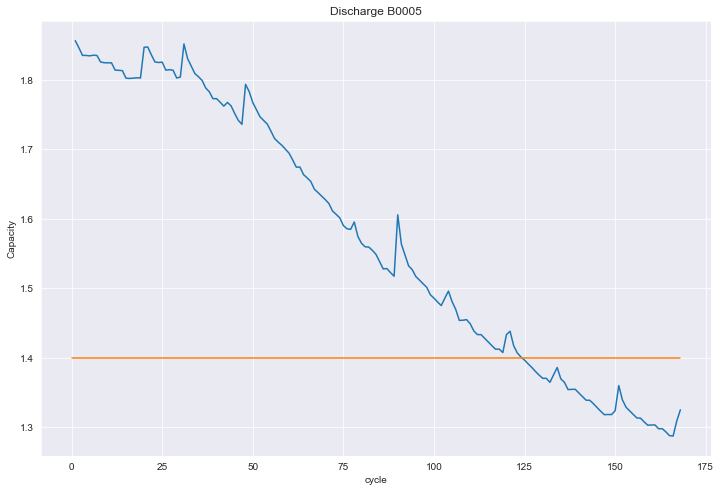

In [4]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

## Train :

In [5]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
dis_ele

,cycle,datetime,capacity,SoH
0,1,2008-04-02 15:25:41,1.856487,1.000000
1,2,2008-04-02 19:43:48,1.846327,0.994527
2,3,2008-04-03 00:01:06,1.835349,0.988614
3,4,2008-04-03 04:16:37,1.835263,0.988567
4,5,2008-04-03 08:33:25,1.834646,0.988235
...,...,...,...,...
163,164,2008-05-26 10:44:38,1.293464,0.696726
164,165,2008-05-26 15:30:43,1.288003,0.693785
165,166,2008-05-26 20:21:04,1.287453,0.693488
166,167,2008-05-27 15:52:41,1.309015,0.705103


Text(0.5, 1.0, 'Discharge B0005')

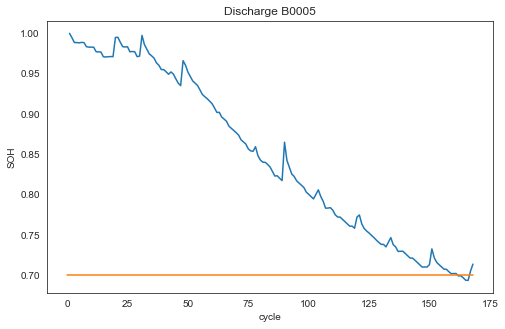

In [6]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [7]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)


(50285, 7)
(50285, 1)


In [8]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 217 (868.00 Byte)
Trainable params: 217 (868.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=70)

Epoch 1/70
2012/2012 [==============================] - 3s 895us/step - loss: 0.1571
Epoch 2/70
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0240
Epoch 3/70
2012/2012 [==============================] - 2s 888us/step - loss: 0.0228
Epoch 4/70
2012/2012 [==============================] - 2s 810us/step - loss: 0.0225
Epoch 5/70
2012/2012 [==============================] - 2s 852us/step - loss: 0.0226
Epoch 6/70
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0224
Epoch 7/70
2012/2012 [==============================] - 2s 848us/step - loss: 0.0228
Epoch 8/70
2012/2012 [==============================] - 2s 957us/step - loss: 0.0224
Epoch 9/70
2012/2012 [==============================] - 2s 815us/step - loss: 0.0220
Epoch 10/70
2012/2012 [==============================] - 2s 842us/step - loss: 0.0223
Epoch 11/70
2012/2012 [==============================] - 2s 965us/step - loss: 0.0225
Epoch 12/70
2012/2012 [==============================] - 2s 924us/s

In [10]:
dataset_val, capacity_val = load_data('B0007')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))


Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.891052          4.199360   
1      1                   24 2008-04-02 15:25:41  1.891052          4.199497   
2      1                   24 2008-04-02 15:25:41  1.891052          3.985606   
3      1                   24 2008-04-02 15:25:41  1.891052          3.963247   
4      1                   24 2008-04-02 15:25:41  1.891052          3.946647   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.001866             23.937044       -0.0004         0.000   0.000  
1         -0.002139             23.924074       -0.0004         4.215  16.781  
2         -1.988778             24.004257       -2.0000         3.003  35.703  
3         -1.99

In [11]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

1572/1572 [==============================] - 1s 688us/step
(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.957728
1      2  0.994492  0.952861
2      3  0.994506  0.952869
3      4  0.994563  0.952919
4      5  0.993865  0.952305
5      6  0.994526  0.952896
6      7  0.994121  0.952536
7      8  0.994953  0.953254
8      9  0.988704  0.947734
9     10  0.988895  0.947906
Root Mean Square Error:  0.029214466746814386


In [13]:
new_soh

,cycle,SoH,NewSoH
0,1,1.000000,0.959915
1,2,0.994492,0.955082
2,3,0.994506,0.955091
3,4,0.994563,0.955136
4,5,0.993865,0.954516
...,...,...,...
163,164,0.743592,0.731602
164,165,0.743679,0.731674
165,166,0.740569,0.729045
166,167,0.751849,0.738641


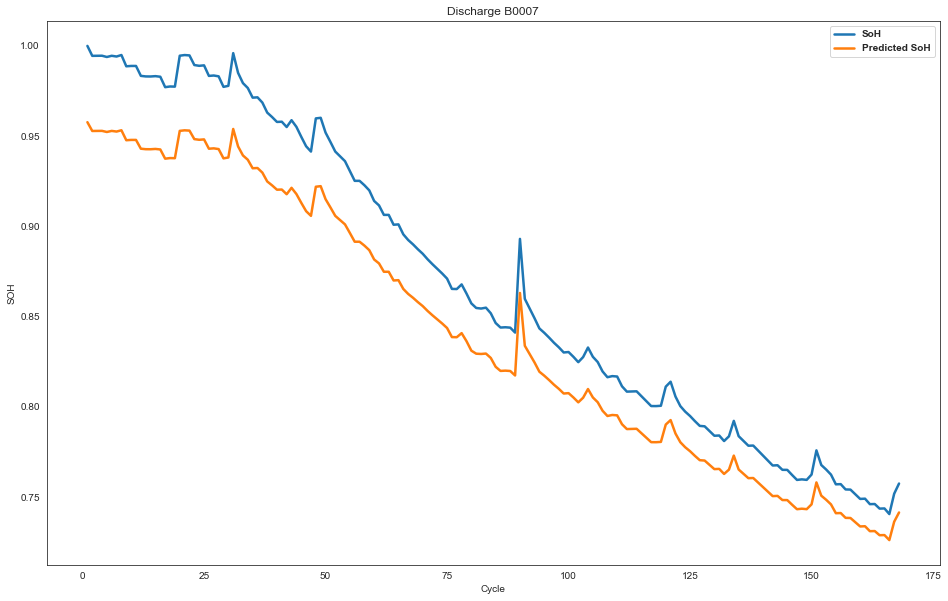

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the data you want to plot
plot_df = new_soh.loc[(new_soh['cycle'] >= 1), ['cycle', 'SoH', 'NewSoH']]

# Set the style of the plot
sns.set_style("white")

# Create the figure with a specified size
plt.figure(figsize=(16, 10))

# Plot the actual and predicted SoH with increased line thickness
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH', linewidth=2.5)
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH', linewidth=2.5)

# Add labels and titles
plt.ylabel('SOH')
plt.xlabel('Cycle')
plt.title('Discharge B0007')

# Customize the legend: bold font and larger size
plt.legend(fontsize=14, loc='best', title_fontsize='13', title='Legend', fancybox=True, shadow=True)
plt.legend(prop={'weight': 'bold'})

# Save the plot as a PDF file
plt.savefig('C:/Users/AHMED/Desktop/projects/battery_soc/pics/soh_discharge_plot_dnn.pdf', format='pdf')

# Display the plot
plt.show()


# LSTM

In [98]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [99]:
train_dataset_lstm = train_dataset.reshape((train_dataset.shape[0], 1, train_dataset.shape[1]))
# Print the current shape of train_dataset
print("Original train_dataset shape:", train_dataset.shape)


# Print the new shape after reshaping
print("Reshaped train_dataset shape:", train_dataset_lstm.shape)

Original train_dataset shape: (50285, 7)
Reshaped train_dataset shape: (50285, 1, 7)


In [100]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(train_dataset_lstm.shape[1], train_dataset_lstm.shape[2]), kernel_regularizer=l2(0.001)))
model_lstm.add(Dropout(0.5))  # Increased Dropout rate
model_lstm.add(Dense(1, kernel_regularizer=l2(0.001)))
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

model_lstm.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               43200     
                                                                 
 dropout_28 (Dropout)        (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 43301 (169.14 KB)
Trainable params: 43301 (169.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
from sklearn.model_selection import train_test_split
train_dataset_lstm = np.array(train_dataset_lstm)
soh = np.array(soh)

X_train, X_val, y_train, y_val = train_test_split(train_dataset_lstm, soh, test_size=0.2, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model
history = model_lstm.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# To access the history
print(history.history)

Epoch 1/50
1258/1258 [==============================] - 4s 2ms/step - loss: 0.1027 - val_loss: 0.0101
Epoch 2/50
1258/1258 [==============================] - 2s 2ms/step - loss: 0.0285 - val_loss: 0.0066
Epoch 3/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.0151 - val_loss: 0.0064
Epoch 4/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.0150 - val_loss: 0.0074
Epoch 5/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.0150 - val_loss: 0.0067
Epoch 6/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.0149 - val_loss: 0.0084
Epoch 7/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.0148 - val_loss: 0.0071
Epoch 8/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.0148 - val_loss: 0.0060
Epoch 9/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 10/50
1258/1258 [==============================] - 3s 2ms/step - loss: 0.014

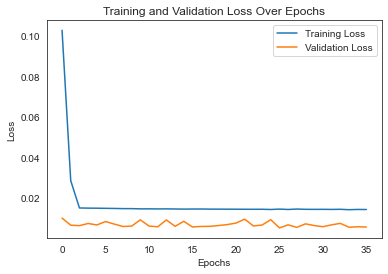

In [102]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [103]:
dataset_val, capacity_val = load_data('B0007')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.891052          4.199360   
1      1                   24 2008-04-02 15:25:41  1.891052          4.199497   
2      1                   24 2008-04-02 15:25:41  1.891052          3.985606   
3      1                   24 2008-04-02 15:25:41  1.891052          3.963247   
4      1                   24 2008-04-02 15:25:41  1.891052          3.946647   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.001866             23.937044       -0.0004         0.000   0.000  
1         -0.002139             23.924074       -0.0004         4.215  16.781  
2         -1.988778             24.004257       -2.0000         3.003  35.703  
3         -1.99

In [104]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assuming `attrib` contains the relevant features for the model
attrib = ['capacity', 'voltage_measured', 'current_measured',
          'temperature_measured', 'current_load', 'voltage_load', 'time']

# Ensure dataset_val is available and properly formatted
sc = StandardScaler()
scaled_data = sc.fit_transform(dataset_val[attrib])

# Reshape the data for LSTM (samples, timesteps, features)
# Assuming timesteps=1 if not using a sequence of data points for prediction
scaled_data_lstm = scaled_data.reshape((scaled_data.shape[0], 1, scaled_data.shape[1]))

# Make predictions with the LSTM model
soh_pred = model_lstm.predict(scaled_data_lstm)
print(soh_pred.shape)

# Calculate actual SoH values
C = dataset_val['capacity'].iloc[0]
soh = dataset_val['capacity'] / C

# Prepare a new DataFrame to store the actual and predicted SoH
new_soh_lstm = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh_lstm['SoH'] = soh.values
new_soh_lstm['NewSoH'] = soh_pred.flatten()  # Flatten predicted SoH to 1D array

# Group by cycle and calculate the mean for each cycle
new_soh_lstm = new_soh_lstm.groupby(['cycle']).mean().reset_index()
print(new_soh_lstm)

# Calculate RMSE
rms = np.sqrt(mean_squared_error(new_soh_lstm['SoH'], new_soh_lstm['NewSoH']))
print('Root Mean Square Error: ', rms)


1572/1572 [==============================] - 2s 897us/step
(50285, 1)
     cycle       SoH    NewSoH
0        1  1.000000  1.195839
1        2  0.994492  1.179000
2        3  0.994506  1.179230
3        4  0.994563  1.179502
4        5  0.993865  1.177268
..     ...       ...       ...
163    164  0.743592  0.761317
164    165  0.743679  0.761317
165    166  0.740569  0.761317
166    167  0.751849  0.761317
167    168  0.757491  0.761317

[168 rows x 3 columns]
Root Mean Square Error:  0.09137004408536721


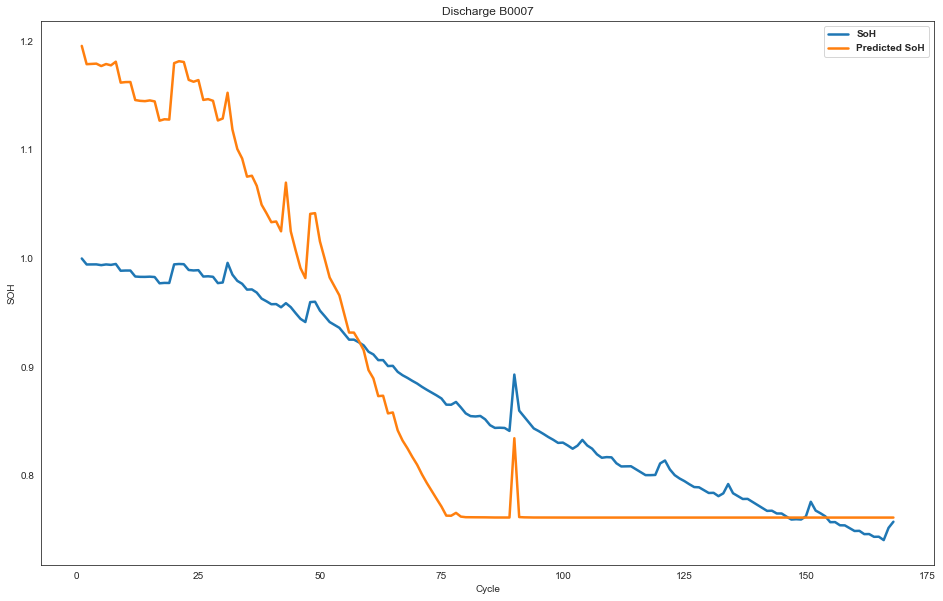

In [105]:

import seaborn as sns
import matplotlib.pyplot as plt

# Select the data you want to plot
plot_df = new_soh_lstm.loc[(new_soh_lstm['cycle'] >= 1), ['cycle', 'SoH', 'NewSoH']]

# Set the style of the plot
sns.set_style("white")

# Create the figure with a specified size
plt.figure(figsize=(16, 10))

# Plot the actual and predicted SoH with increased line thickness
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH', linewidth=2.5)
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH', linewidth=2.5)

# Add labels and titles
plt.ylabel('SOH')
plt.xlabel('Cycle')
plt.title('Discharge B0007')

# Customize the legend: bold font and larger size
plt.legend(fontsize=14, loc='best', title_fontsize='13', title='Legend', fancybox=True, shadow=True)
plt.legend(prop={'weight': 'bold'})

# Save the plot as a PDF file
plt.savefig('C:/Users/AHMED/Desktop/projects/battery_soc/pics/soh_discharge_plot_lstm.pdf', format='pdf')

# Display the plot
plt.show()


# CNN


In [87]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization


# Reshape the data to fit Conv1D input requirements
train_dataset_reshaped = train_dataset.reshape((train_dataset.shape[0], train_dataset.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_dataset_reshaped.shape[1], 1), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.5))

model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.5))

model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
model_cnn.add(Dense(1))

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Assuming `soh` is the target variable
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_dataset_reshaped, soh, test_size=0.2, random_state=42)

# Fit the model

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history = model_cnn.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

# To access the history
print(history.history)

Epoch 1/50
1258/1258 [==============================] - 5s 3ms/step - loss: 0.1823 - val_loss: 0.0637
Epoch 2/50
1258/1258 [==============================] - 4s 3ms/step - loss: 0.0413 - val_loss: 0.0273
Epoch 3/50
1258/1258 [==============================] - 4s 3ms/step - loss: 0.0185 - val_loss: 0.0101
Epoch 4/50
1258/1258 [==============================] - 4s 3ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 5/50
1258/1258 [==============================] - 4s 3ms/step - loss: 0.0020 - val_loss: 5.5588e-04
Epoch 6/50
1258/1258 [==============================] - 4s 3ms/step - loss: 7.1884e-04 - val_loss: 2.6534e-04
Epoch 7/50
1258/1258 [==============================] - 4s 3ms/step - loss: 4.9987e-04 - val_loss: 1.4605e-04
Epoch 8/50
1258/1258 [==============================] - 4s 3ms/step - loss: 4.1550e-04 - val_loss: 1.1494e-04
Epoch 9/50
1258/1258 [==============================] - 4s 3ms/step - loss: 3.3476e-04 - val_loss: 9.0921e-05
Epoch 10/50
1258/1258 [=======================

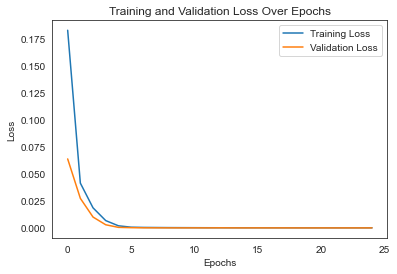

In [88]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
dataset_val, capacity_val = load_data('B0007')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.891052          4.199360   
1      1                   24 2008-04-02 15:25:41  1.891052          4.199497   
2      1                   24 2008-04-02 15:25:41  1.891052          3.985606   
3      1                   24 2008-04-02 15:25:41  1.891052          3.963247   
4      1                   24 2008-04-02 15:25:41  1.891052          3.946647   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.001866             23.937044       -0.0004         0.000   0.000  
1         -0.002139             23.924074       -0.0004         4.215  16.781  
2         -1.988778             24.004257       -2.0000         3.003  35.703  
3         -1.99

In [90]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assuming `attrib` contains the relevant features for the model
attrib = ['capacity', 'voltage_measured', 'current_measured',
          'temperature_measured', 'current_load', 'voltage_load', 'time']


# Reshape the data for CNN (samples, timesteps, features)
# CNN typically expects 3D data: (samples, timesteps, features)
# If using Conv1D, we treat timesteps as a sequence length, set timesteps to 1 for single-step predictions
scaled_data_cnn = scaled_data.reshape((scaled_data.shape[0], scaled_data.shape[1], 1))

# Make predictions with the CNN model
soh_pred_cnn = model_cnn.predict(scaled_data_cnn)
print(soh_pred_cnn.shape)

# Calculate actual SoH values
C = dataset_val['capacity'].iloc[0]
soh = dataset_val['capacity'] / C

# Prepare a new DataFrame to store the actual and predicted SoH
new_soh_cnn = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh_cnn['SoH'] = soh.values
new_soh_cnn['NewSoH'] = soh_pred_cnn.flatten()  # Flatten predicted SoH to 1D array

# Group by cycle and calculate the mean for each cycle
new_soh_cnn = new_soh_cnn.groupby(['cycle']).mean().reset_index()
print(new_soh_cnn)

# Calculate RMSE
rms_cnn = np.sqrt(mean_squared_error(new_soh_cnn['SoH'], new_soh_cnn['NewSoH']))
print('Root Mean Square Error: ', rms_cnn)


1572/1572 [==============================] - 2s 1ms/step
(50285, 1)
     cycle       SoH    NewSoH
0        1  1.000000  1.106420
1        2  0.994492  1.101986
2        3  0.994506  1.098771
3        4  0.994563  1.095130
4        5  0.993865  1.094056
..     ...       ...       ...
163    164  0.743592  0.728558
164    165  0.743679  0.728286
165    166  0.740569  0.728227
166    167  0.751849  0.728421
167    168  0.757491  0.729633

[168 rows x 3 columns]
Root Mean Square Error:  0.05965185381470039


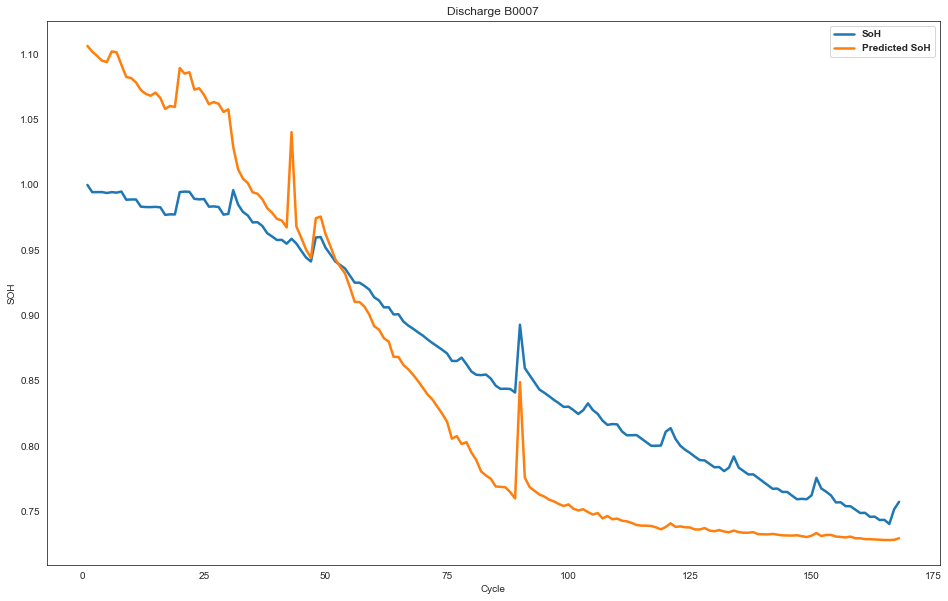

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the data you want to plot
plot_df = new_soh_cnn.loc[(new_soh_cnn['cycle'] >= 1), ['cycle', 'SoH', 'NewSoH']]

# Set the style of the plot
sns.set_style("white")

# Create the figure with a specified size
plt.figure(figsize=(16, 10))

# Plot the actual and predicted SoH with increased line thickness
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH', linewidth=2.5)
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH', linewidth=2.5)

# Add labels and titles
plt.ylabel('SOH')
plt.xlabel('Cycle')
plt.title('Discharge B0007')

# Customize the legend: bold font and larger size
plt.legend(fontsize=14, loc='best', title_fontsize='13', title='Legend', fancybox=True, shadow=True)
plt.legend(prop={'weight': 'bold'})

# Save the plot as a PDF file
plt.savefig('C:/Users/AHMED/Desktop/projects/battery_soc/pics/soh_discharge_plot_cnn.pdf', format='pdf')

# Display the plot
plt.show()


[0]	validation_0-rmse:0.08842	validation_1-rmse:0.08847
[1]	validation_0-rmse:0.07959	validation_1-rmse:0.07964
[2]	validation_0-rmse:0.07164	validation_1-rmse:0.07168
[3]	validation_0-rmse:0.06449	validation_1-rmse:0.06453
[4]	validation_0-rmse:0.05805	validation_1-rmse:0.05808
[5]	validation_0-rmse:0.05225	validation_1-rmse:0.05228
[6]	validation_0-rmse:0.04703	validation_1-rmse:0.04706
[7]	validation_0-rmse:0.04234	validation_1-rmse:0.04236
[8]	validation_0-rmse:0.03811	validation_1-rmse:0.03813
[9]	validation_0-rmse:0.03430	validation_1-rmse:0.03432
[10]	validation_0-rmse:0.03088	validation_1-rmse:0.03090
[11]	validation_0-rmse:0.02779	validation_1-rmse:0.02781
[12]	validation_0-rmse:0.02502	validation_1-rmse:0.02503
[13]	validation_0-rmse:0.02252	validation_1-rmse:0.02253
[14]	validation_0-rmse:0.02027	validation_1-rmse:0.02028
[15]	validation_0-rmse:0.01825	validation_1-rmse:0.01826
[16]	validation_0-rmse:0.01643	validation_1-rmse:0.01643
[17]	validation_0-rmse:0.01479	validation

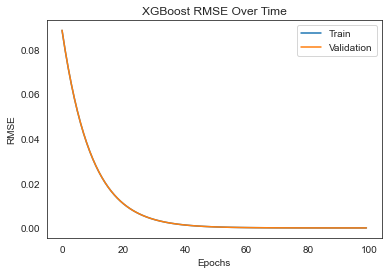

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_dataset, soh, test_size=0.2, random_state=42)

# Create the XGBRegressor model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse')

# Define the eval set
eval_set = [(X_train, y_train), (X_val, y_val)]

# Fit the model with early stopping
model.fit(X_train, y_train, 
          eval_set=eval_set, 
          verbose=True)

# Retrieve performance metrics
results = model.evals_result()

# Plotting the RMSE for training and validation
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Time')
plt.legend()
plt.show()


In [19]:
dataset_val, capacity_val = load_data('B0007')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.891052          4.199360   
1      1                   24 2008-04-02 15:25:41  1.891052          4.199497   
2      1                   24 2008-04-02 15:25:41  1.891052          3.985606   
3      1                   24 2008-04-02 15:25:41  1.891052          3.963247   
4      1                   24 2008-04-02 15:25:41  1.891052          3.946647   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.001866             23.937044       -0.0004         0.000   0.000  
1         -0.002139             23.924074       -0.0004         4.215  16.781  
2         -1.988778             24.004257       -2.0000         3.003  35.703  
3         -1.99

In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assuming `attrib` contains the relevant features for the model
attrib = ['capacity', 'voltage_measured', 'current_measured',
          'temperature_measured', 'current_load', 'voltage_load', 'time']


# Reshape the data for CNN (samples, timesteps, features)
# CNN typically expects 3D data: (samples, timesteps, features)
# If using Conv1D, we treat timesteps as a sequence length, set timesteps to 1 for single-step predictions
scaled_data_cnn = scaled_data.reshape((scaled_data.shape[0], scaled_data.shape[1], 1))

# Make predictions with the CNN model
soh_pred_cnn = model_cnn.predict(scaled_data_cnn)
print(soh_pred_cnn.shape)

# Calculate actual SoH values
C = dataset_val['capacity'].iloc[0]
soh = dataset_val['capacity'] / C

# Prepare a new DataFrame to store the actual and predicted SoH
new_soh_cnn = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh_cnn['SoH'] = soh.values
new_soh_cnn['NewSoH'] = soh_pred_cnn.flatten()  # Flatten predicted SoH to 1D array

# Group by cycle and calculate the mean for each cycle
new_soh_cnn = new_soh_cnn.groupby(['cycle']).mean().reset_index()
print(new_soh_cnn)

# Calculate RMSE
rms_cnn = np.sqrt(mean_squared_error(new_soh_cnn['SoH'], new_soh_cnn['NewSoH']))
print('Root Mean Square Error: ', rms_cnn)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:datetime: datetime64[ns]